# Postprocessing a DeepONet Trained for a 0D Reactor

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from tensorflow                           import keras

import romnet                             as rmnt

In [2]:
### Input Data

ROMNetFldr    = WORKSPACE_PATH + '/ROMNet/romnet/'

OutputDir     = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_100Cases_Highest/'
TestDir       = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_100Cases_Highest/'

PathToRunFld  = WORKSPACE_PATH + '/ROMNet/0DReact_Isobaric_100Cases_Highest/DeepONet/Deterministic/Run_3/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/0DReact_10Cases/DeepONet/MCDropOut/Run_1/'
#PathToRunFld  = WORKSPACE_PATH + '/ROMNet/0DReact_10Cases/DeepONet/BayesByBackprop/Run_1/'

DirDir        = OutputDir

# DirName       = 'test'
# CasesVec      = range(5)#[1,0,2]
DirName       = 'train'
CasesVec      = range(0,100,20)



NSamples      = 1

NVarsRed      = 7

FixedMinVal   = 1.e-14 

In [3]:
print("\n[ROMNet]: Reading Input File from: ", PathToRunFld)
sys.path.insert(0, PathToRunFld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH, ROMNetFldr)


InputData.InputFilePath = PathToRunFld+'/ROMNet_Input.py'
InputData.TrainIntFlg   = 0
InputData.PathToRunFld  = PathToRunFld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE//ROMNet/0DReact_Isobaric_100Cases_Highest/DeepONet/Deterministic/Run_3/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


In [4]:
SurrogateType = InputData.SurrogateType
if (SurrogateType == 'FNN-SourceTerms'):
    SurrogateType = 'FNN'

Net   = getattr(rmnt.nn, SurrogateType)

model = rmnt.model.Model_Deterministic(InputData)

model.build(InputData, None, Net)#, loadfile_no='000004')

NN    = model.net


[ROMNet]:   Initializing the ML Model

[ROMNet]:   Building the ML Model

[ROMNet]:   Loading ML Model Parameters from File:  /Users/sventur/WORKSPACE//ROMNet/0DReact_Isobaric_100Cases_Highest/DeepONet/Deterministic/Run_3//Training/Params//000001.h5
'load_params' took 0.071092 s


[ROMNet]:   Saving ML Model Parameters to File:  /Users/sventur/WORKSPACE//ROMNet/0DReact_Isobaric_100Cases_Highest/DeepONet/Deterministic/Run_3//Model/Params/Initial.h5
'save_params' took 0.071336 s

'build' took 2.657018 s



In [5]:
FileName = OutputDir+'/'+str(NVarsRed)+'PC/ROM/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/'+str(NVarsRed)+'PC/ROM/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/'+str(NVarsRed)+'PC/ROM/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName    = OutputDir+'/'+str(NVarsRed)+'PC/ROM/ToOrig_Mask.csv'
ToOrig_Mask = pd.read_csv(FileName, delimiter=',', header=None).to_numpy(int)[:,0]

In [6]:
### Evaluating on Test Data


FileName = DirDir + '/Orig/train/ext/y.csv.1'
Data     = pd.read_csv(FileName, header=0)
VarNames = list(Data.columns)
VarNames.remove('t')

FileName     = DirDir + '/Orig/train/ext/CleanVars.csv'
Data         = pd.read_csv(FileName, header=0)
VarNamesAnti = list(Data.columns)

        
        
Vars = []
for iVars in range(1,NVarsRed+1):
    Vars.append('PC_'+str(iVars))

Vars0 = []
for iVars in range(1,NVarsRed+1):
    Vars0.append('PC0_'+str(iVars))
    
SVars = []
for iVars in range(1,NVarsRed+1):
    SVars.append('SPC_'+str(iVars))
    


FileName     = OutputDir + '/Orig/'+DirName+'/ext/SimIdxs.csv'
Data         = pd.read_csv(FileName, header=0)
SimIdxs      = Data.to_numpy(int)

FileName     = OutputDir + '/Orig/'+DirName+'/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
NICs         = len(ICVecs)

In [7]:
InputVars = Vars0+['t']
#InputVars = ['T0']+['t']
InputVars

['PC0_1', 'PC0_2', 'PC0_3', 'PC0_4', 'PC0_5', 'PC0_6', 'PC0_7', 't']

T =  1675.0 K
T =  1945.0 K
T =  1815.0 K
T =  1175.0 K
T =  1405.0 K


(1e-06, 0.1)

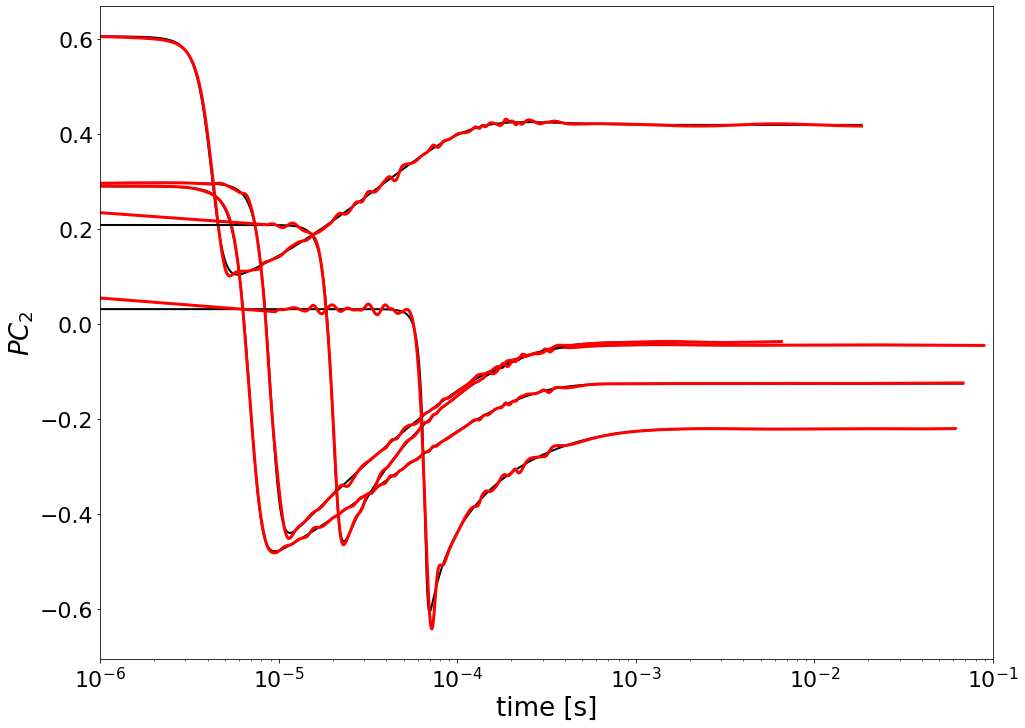

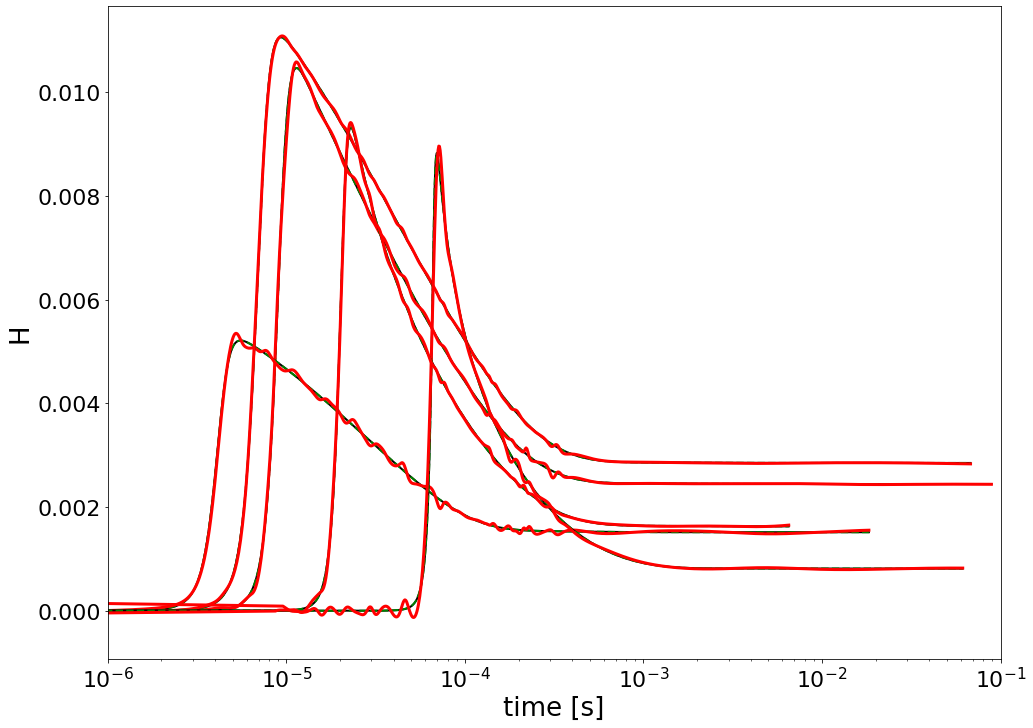

In [8]:
iPC      = 1

VarOI    = 'H'




iVar     = VarNames.index(VarOI)
iVarAnti = VarNamesAnti.index(VarOI)



ax  = []

fig = plt.figure(figsize=(16,12))
ax.append(plt.axes())

fig = plt.figure(figsize=(16,12))
ax.append(plt.axes())
for iTest in CasesVec:
    Nts              = SimIdxs[iTest,1]-SimIdxs[iTest,0]
    P0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,0]
    EqRatio0Vec      = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,1]
    T0Vec            = np.ones(Nts, dtype=np.float64)*ICVecs[iTest,2]
    
    
    #####################################################################################################
    FileName     = DirDir + '/Orig/'+DirName+'/ext/y.csv.'+str(iTest+1)
    Data         = pd.read_csv(FileName, header=0)
    tVec         = Data.to_numpy()[:,0]
    tVec[tVec == 0.] = FixedMinVal
    y_Data       = Data[VarNames].to_numpy()
    print('T = ', Data['T'].to_numpy()[0], 'K')
    

    #####################################################################################################
#     FileName         = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iTest+1)
#     Data             = pd.read_csv(FileName, header=0)
#     tVec             = np.maximum(Data['t'].to_numpy(), -1)#FixedMinVal)
#     yPCA_Data        = Data[Vars].to_numpy()
#     Data0            = Data[Data['t'] == 0.][Vars]
    yPCA_Data        = ((y_Data[:,ToOrig_Mask] - C[:,0])/D[:,0]).dot(A.T)
    yPre_Data        = yPCA_Data.dot(A)
    yAnti_Data       = yPre_Data * D[:,0] + C[:,0]
    Data0            = pd.DataFrame([yPCA_Data[1,:]], columns=Vars0)
    
    Data0            = Data0.loc[Data0.index.repeat(Nts)]
    Data0.columns    = Vars0
    Data0['T0']      = T0Vec
    Data0['t']       = tVec
    Data0['log10(t)']= np.log10(tVec)
    Data0['log(t)']  = np.log(tVec)
    Data0.reset_index(drop=True, inplace=True)
        
    
    ax[0].plot(tVec, yPCA_Data[:,iPC], '-k',  label='From ODE', lw=2)
    ax[1].plot(tVec, y_Data[:,iVar],  '-k',  label='From ODE', lw=2)
    ax[1].plot(tVec, yAnti_Data[:,iVarAnti], '--g',  label='From PCA', lw=2)
    
    
    if (InputData.ProbApproach == 'Deterministic') and (NSamples == 1):
        
        yPCA_Pred  = model.predict(Data0[InputVars])
        yPre_Pred  = yPCA_Pred.dot(A)
        yAnti_Pred = (yPre_Pred)*D[:,0] + C[:,0]
    
        ax[0].plot(tVec, yPCA_Pred[:,iPC], 'r-', label='DeepONet', lw=3)
        ax[1].plot(tVec, yAnti_Pred[:,iVarAnti], 'r-', label='DeepONet', lw=3)
        
    else:
        
        ### Sampling NN
        yPCA_Pred_sum  = np.zeros((yPCA_Data.shape[0], yPCA_Data.shape[1]))
        yPCA_Pred_sqr  = np.zeros((yPCA_Data.shape[0], yPCA_Data.shape[1]))
        yAnti_Pred_sum = np.zeros((yAnti_Data.shape[0], A.shape[1]))
        yAnti_Pred_sqr = np.zeros((yAnti_Data.shape[0], A.shape[1]))

        for iSample in range(NSamples):
            yPCA_Pred = model.predict(Data0[InputVars])
            
            yPCA_Pred_sum  += yPCA_Pred
            yPCA_Pred_sqr  += yPCA_Pred**2
            
            yAnti_Pred      = (yPCA_Pred.dot(A))*D[:,0] + C[:,0]
            yAnti_Pred_sum += yAnti_Pred
            yAnti_Pred_sqr += yAnti_Pred**2
            
        yMat_pca_mean = yPCA_Pred_sum/NSamples
        yMat_pca_std  = np.sqrt( yPCA_Pred_sqr/NSamples - yMat_pca_mean**2 )
        yMat_pca_p1   = yMat_pca_mean + 1.*yMat_pca_std
        yMat_pca_m1   = yMat_pca_mean - 1.*yMat_pca_std
        yMat_pca_p2   = yMat_pca_mean + 2.*yMat_pca_std
        yMat_pca_m2   = yMat_pca_mean - 2.*yMat_pca_std
        yMat_pca_p3   = yMat_pca_mean + 3.*yMat_pca_std
        yMat_pca_m3   = yMat_pca_mean - 3.*yMat_pca_std
            

        yMat_mean = yAnti_Pred_sum/NSamples
        yMat_std  = np.sqrt( yAnti_Pred_sqr/NSamples - yMat_mean**2 )
        yMat_p1   = yMat_mean + 1.*yMat_std
        yMat_m1   = yMat_mean - 1.*yMat_std
        yMat_p2   = yMat_mean + 2.*yMat_std
        yMat_m2   = yMat_mean - 2.*yMat_std
        yMat_p3   = yMat_mean + 3.*yMat_std
        yMat_m3   = yMat_mean - 3.*yMat_std
    
        ax[0].plot(tVec, yMat_pca_mean[:,iPC], 'b-', label=r'DeepONet, $\mu$')
        ax[0].plot(tVec, yMat_pca_p3[:,iPC],   'b:', label=r'DeepONet, $\mu+3\sigma$')
        ax[0].plot(tVec, yMat_pca_m3[:,iPC],   'b:', label=r'DeepONet, $\mu-3\sigma$')

        ax[1].plot(tVec, yMat_mean[:,iVarAnti],  'b-', label=r'DeepONet, $\mu$')
        ax[1].plot(tVec, yMat_p3[:,iVarAnti],    'b:', label=r'DeepONet, $\mu+3\sigma$')
        ax[1].plot(tVec, yMat_m3[:,iVarAnti],  'b:', label=r'DeepONet, $\mu-3\sigma$')
    
    
ax[0].set_xscale('log')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel(r'$PC_'+str(iPC+1)+'$')
ax[0].set_xlim([1.e-6,1.e-1])
#ax[0].legend()

ax[1].set_xscale('log')
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel(VarOI)
ax[1].set_xlim([1.e-6,1.e-1])
#ax[1].legend()

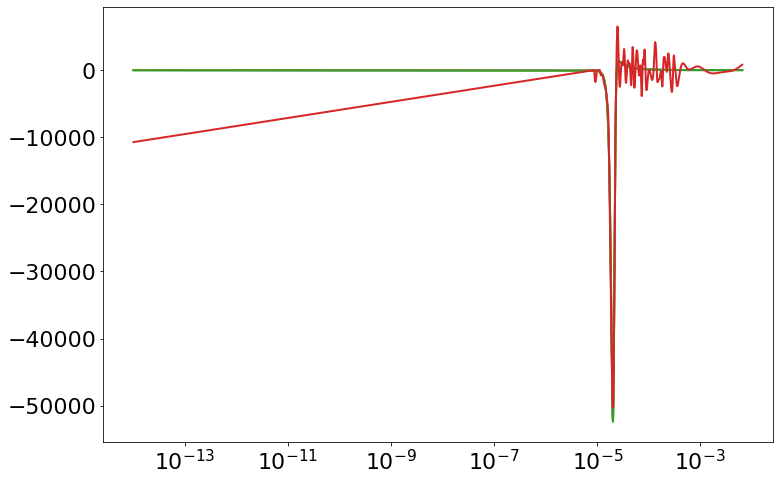

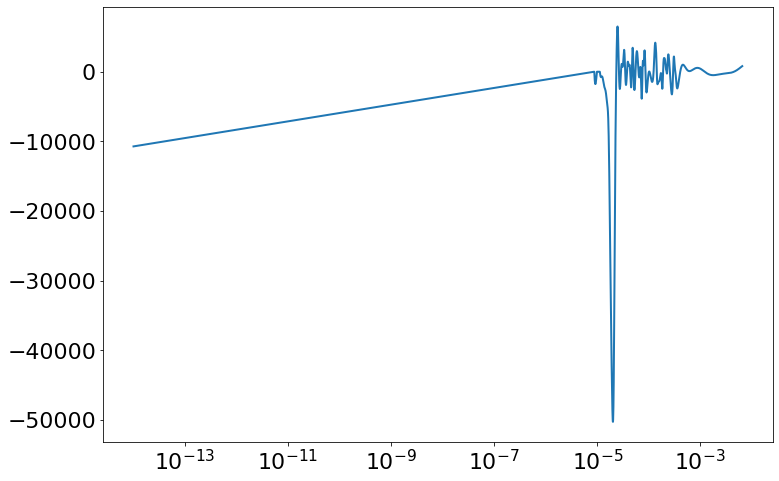

In [9]:
VarOI    = 'H2'

iVar     = VarNames.index(VarOI)
iVarAnti = VarNamesAnti.index(VarOI)


FileName      = DirDir + '/Orig/'+DirName+'/ext/ySource.csv.' + str(iTest+1)
DataSource    = pd.read_csv(FileName, header=0)
dydtAnti_Data = DataSource[VarNamesAnti].to_numpy()
dydtPre_Data  = dydtAnti_Data/D.T


ZeroDR  = rmnt.pinn.system.ZeroDR(InputData)

yPre_RealData      = (y_Data[:,ZeroDR.to_orig] - ZeroDR.C) / ZeroDR.D
dydtPre_RealData_f = ZeroDR.f(0., yPre_RealData, None)
dydtPre_RealData_n = np.gradient(yPre_RealData[:,iVarAnti], tVec) #* tVec[:,0]

dydtPre_Data_f     = ZeroDR.f(0., yPre_Data, None)
dydtPre_Data_n     = np.gradient(yPre_Data[:,iVarAnti], tVec) #* tVec[:,0]

dydtPre_Pred_f     = ZeroDR.f(0., yPre_Pred,  None)
dydtPre_Pred_n     = np.gradient(yPre_Pred[:,iVarAnti], tVec) #* tVec[:,0]

fig = plt.figure(figsize=(12,8))
plt.plot(tVec, dydtPre_Data[:,iVarAnti])
plt.plot(tVec, dydtPre_RealData_f[:,iVarAnti])
plt.plot(tVec, dydtPre_Data_f[:,iVarAnti])
plt.plot(tVec, dydtPre_Pred_f[:,iVarAnti])
plt.xscale('log')
# plt.xlim([1.e-14,1.e-13])
# plt.ylim([-1e9, 1e7])


fig = plt.figure(figsize=(12,8))

#plt.plot(tVec, dydtPre_RealData_f[:,iVarAnti])
#plt.plot(tVec, dydtPre_RealData_n)

# plt.plot(tVec, dydtPre_Data_f[:,iVarAnti])
#plt.plot(tVec, dydtPre_Data_n)

plt.plot(tVec, dydtPre_Pred_f[:,iVarAnti])
#plt.plot(tVec, dydtPre_Pred_n)

plt.xscale('log')
# plt.xlim([1.e-14,1.e-13])
# plt.ylim([-1e9, 1e7])

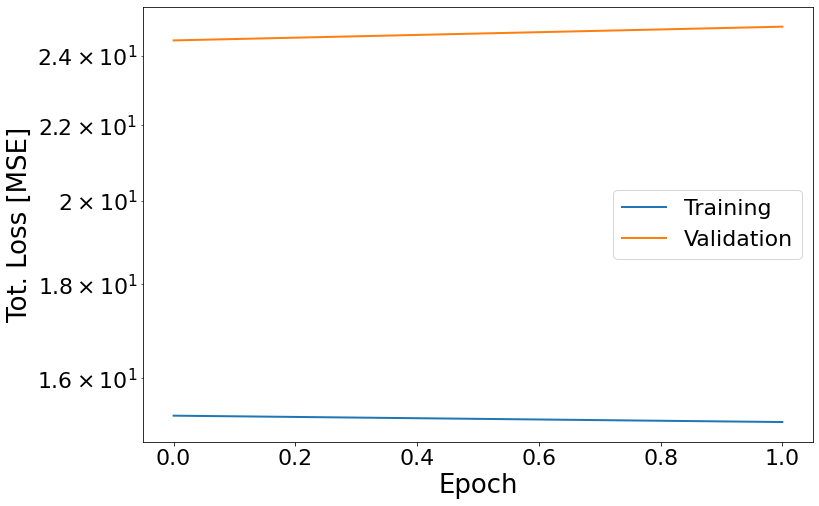

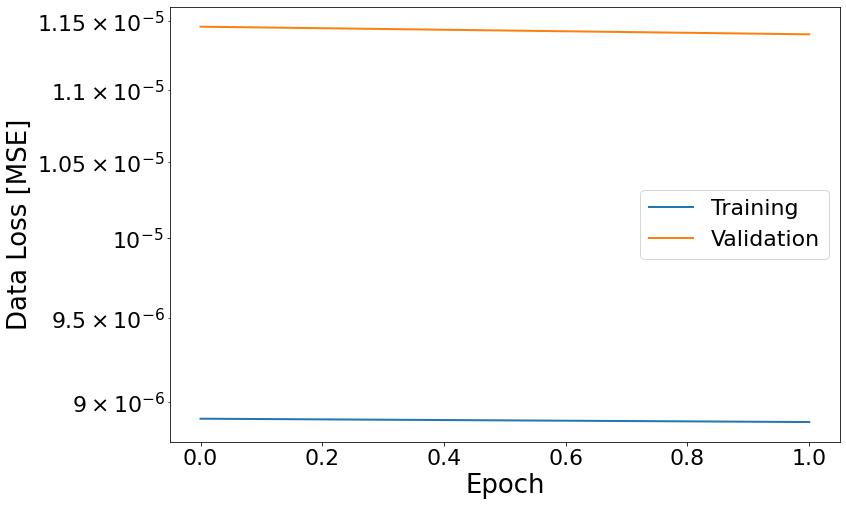

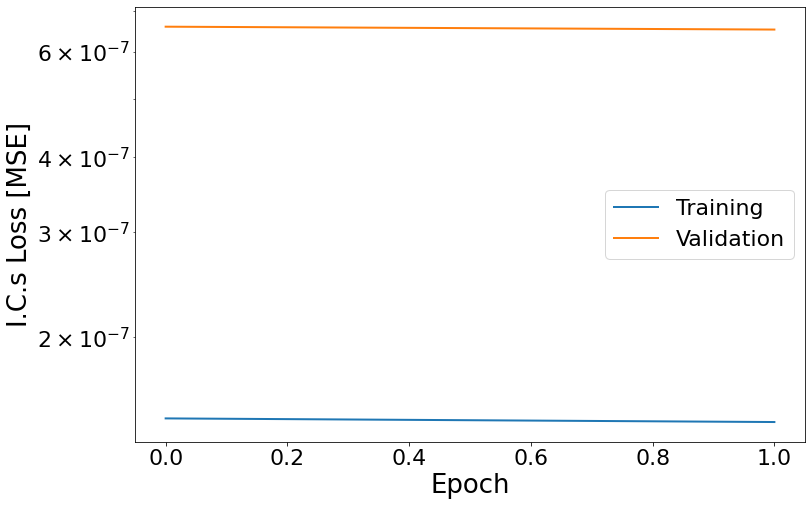

In [10]:
Data = pd.read_csv(PathToRunFld+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['res_loss'],     label='Training')
# plt.plot(Data['val_res_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Residual Loss [MSE]')
# plt.legend()
# plt.yscale('log')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['scs_loss'],     label='Training')
plt.plot(Data['val_scs_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('I.C.s Loss [MSE]')
plt.legend()
plt.yscale('log')

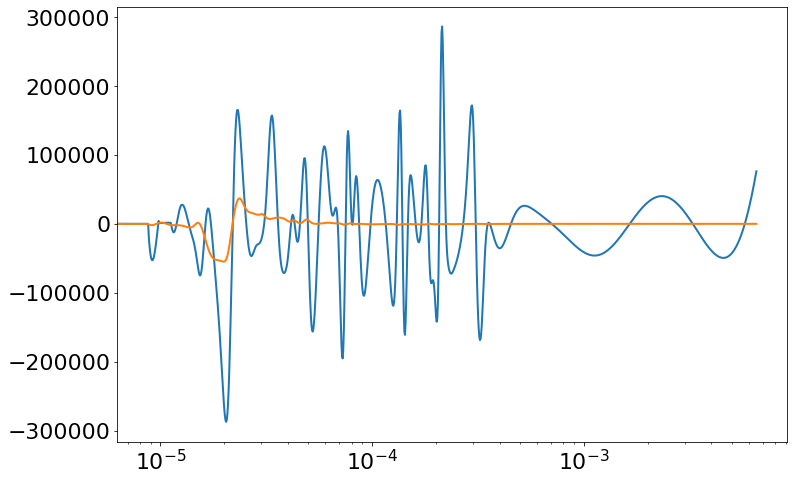

In [22]:
iPC = 6

FileName       = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iTest+1)
Data           = pd.read_csv(FileName, header=0)
tVec           = np.maximum(Data['t'].to_numpy(), -1)#FixedMinVal)
yPCA_Data      = Data[Vars].to_numpy()

FileName       = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PCSource.csv.'+str(iTest+1)
DataSource     = pd.read_csv(FileName, header=0)
dPCdt_Data     = DataSource[SVars].to_numpy()

dPCdt_Data_f   = ZeroDR.f_pc(0., yPCA_Data,  None)
dPCdt_Data_n   = np.gradient(yPCA_Data[:,iPC], tVec) #* tVec[:,0]

dPCdt_Pred_f   = ZeroDR.f_pc(0., yPCA_Pred,  None)
dPCdt_Pred_n   = np.gradient(yPCA_Pred[:,iPC], tVec) #* tVec[:,0]



fig = plt.figure(figsize=(12,8))

#plt.plot(tVec, dPCdt_Data[:,iPC])

#plt.plot(tVec, dPCdt_Data_f[:,iPC])
#plt.plot(tVec, dPCdt_Data_n)

plt.plot(tVec, dPCdt_Pred_f[:,iPC]/model.y_range[iPC])
plt.plot(tVec, dPCdt_Pred_n/model.y_range[iPC])

plt.xscale('log')
# plt.xlim([1.e-14,1.e-13])
# plt.ylim([-1e9, 1e7])

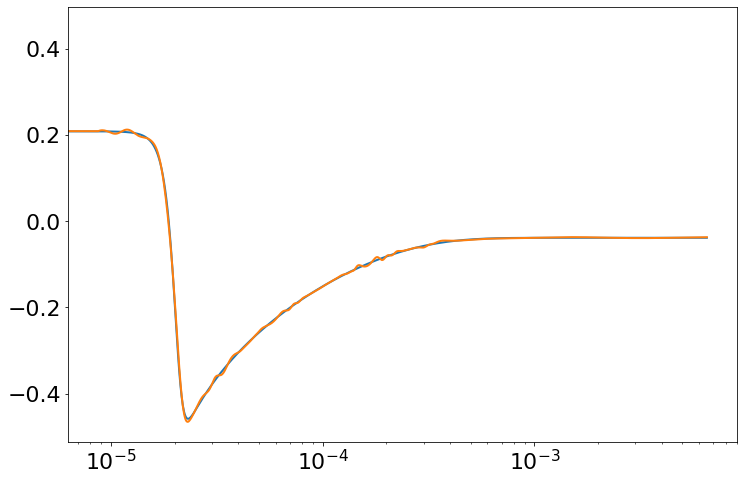

In [12]:
fig = plt.figure(figsize=(12,8))
plt.plot(tVec, yPCA_Data[:,iPC])
plt.plot(tVec, yPCA_Pred[:,iPC])
plt.xscale('log')
# plt.xlim([1.e-14,1.e-13])
# plt.ylim([-1e9, 1e7])

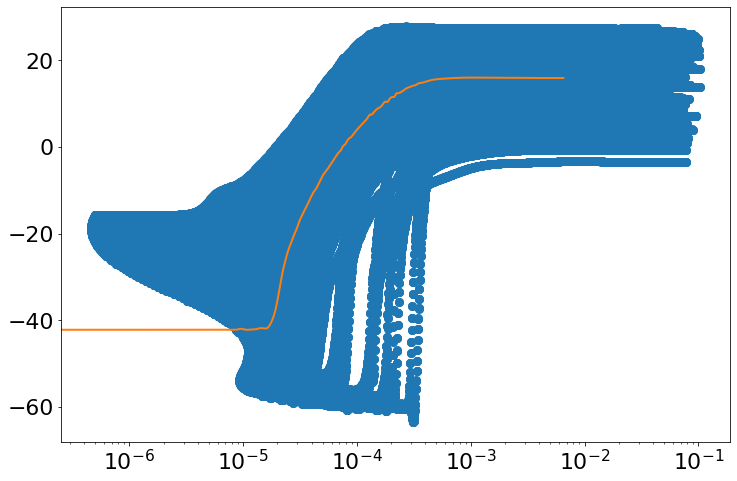

In [13]:
iPC = 0

fig = plt.figure(figsize=(12,8))

DataIn = pd.read_csv('/Users/sventur/Desktop/DAJE/Input.csv', header=None).to_numpy()
plt.plot(DataIn[:,0], DataIn[:,iPC+1], 'o')

plt.plot(tVec, yPCA_Pred[:,iPC])

plt.xscale('log')

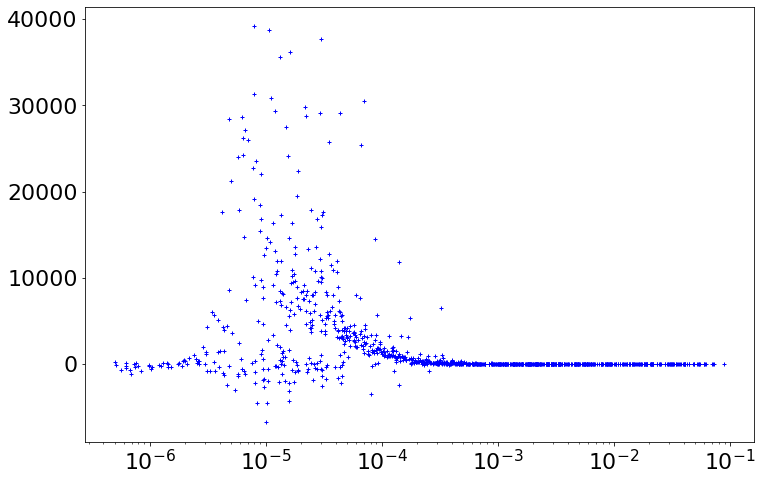

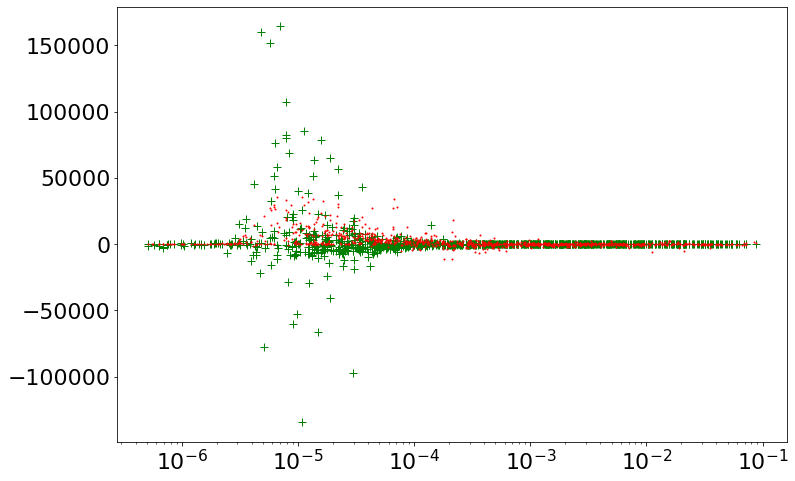

In [14]:
Data = pd.read_csv('/Users/sventur/Desktop/DAJE/Output.csv', header=None).to_numpy()

dPCdt_Pred_f   = ZeroDR.f_pc(0., DataIn[:,1:],  None)
#dPCdt_Pred_n   = np.gradient(DataIn[-1000:-1,iPC+1], DataIn[-1000:-1,0]) #* tVec[:,0]



fig = plt.figure(figsize=(12,8))

plt.plot(Data[-1000:-1,0], Data[-1000:-1,iPC+1],   'b+', markersize=4)
#plt.plot(DataIn[-1000:-1,0], dPCdt_Pred_n/model.y_range[iPC], 'ro', markersize=1)

plt.xscale('log')
# plt.xlim([-5, -4])
# plt.ylim([-1, -0.9])



fig = plt.figure(figsize=(12,8))

plt.plot(Data[-1000:-1,0], Data[-1000:-1,iPC+6], 'g+', markersize=8)
plt.plot(DataIn[-1000:-1,0], dPCdt_Pred_f[-1000:-1,iPC]/model.y_range[iPC], 'ro', markersize=1)

plt.xscale('log')
# plt.xlim([-5, -4])
# plt.ylim([-1, -0.9])

Text(0, 0.5, 'T [K]')

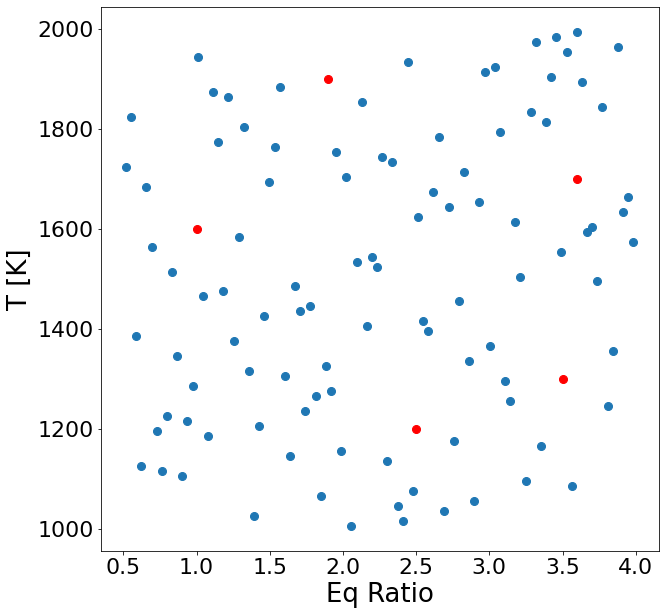

In [15]:
Data    = pd.read_csv(OutputDir+'/Orig/train/ext/ICs.csv')

ICs      = np.zeros((5,2))
ICs[:,0] = [2.5, 1.9, 3.5, 1., 3.6]
ICs[:,1] = [1200., 1900., 1300., 1600., 1700.]

plt.figure(figsize=(10,10))
plt.plot(Data.EqRatio, Data['T'], 'o')
plt.plot(ICs[:,0],ICs[:,1],'ro')
plt.xlabel('Eq Ratio')
plt.ylabel('T [K]')